In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from mealpy import FloatVar, ARO

import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv('../data/VCB.csv')

In [ ]:
data.head(10)

,Unnamed: 0,time,open,high,low,close,volume
0,0,1/2/2018,86.12,86.31,85.50,85.95,22483797
1,1,1/3/2018,86.06,86.51,85.97,86.35,26061439
2,2,1/4/2018,86.59,87.66,86.57,87.11,21911974
3,3,1/5/2018,87.66,88.41,87.43,88.19,23407110
4,4,1/8/2018,88.20,88.58,87.60,88.28,22113049
5,5,1/9/2018,88.65,88.73,87.86,88.22,19484317
6,6,1/10/2018,87.86,88.19,87.41,87.82,18652201
7,7,1/11/2018,88.13,88.13,87.24,88.08,17808877
8,8,1/12/2018,88.67,89.78,88.45,89.60,24271531
9,9,1/16/2018,90.10,90.79,88.01,88.35,36599736


In [15]:
data30=data30[['close']]

C:\Users\DELL\AppData\Local\Temp\ipykernel_5096\3292787498.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


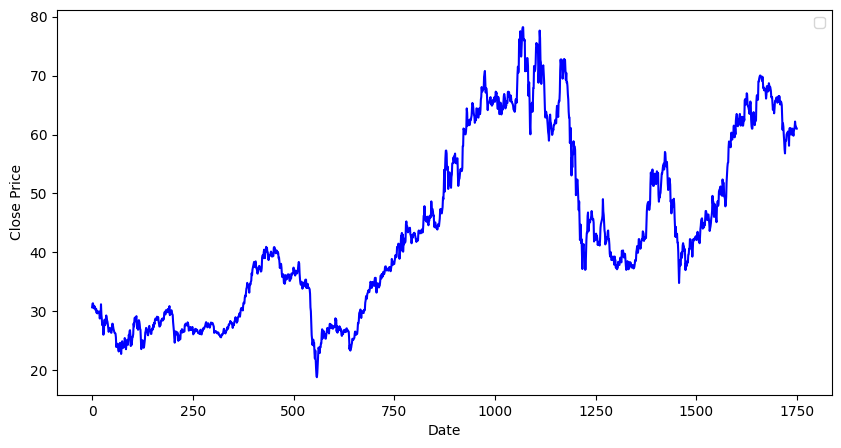

In [78]:
plt.figure(figsize=(10, 5))  #
plt.plot(data[['close']],color='blue')   #
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [3]:
def process_data(data):
    #định dạng lại cấu trúc thời gian
    data['time']=pd.to_datetime(data.time, format='mixed' ,dayfirst=False)

    #Lấy cột Close
    data=data[['close']]

    # Chia tập dữ liệu thành train/test (80% train, 20% test)
    x_train, x_test = train_test_split(data, test_size=0.2, shuffle=False)

    # Khởi tạo scaler
    scaler = MinMaxScaler(feature_range=(0, 1))

    # Fit scaler trên tập huấn luyện và transform cả train lẫn test
    train_scaled = scaler.fit_transform(x_train)
    test_scaled = scaler.transform(x_test)

    #Tạo vòng lặp giá trị, lấy 60 ngày trong quá khứ để dự đoán ngày tiếp theo
    x_train = []
    y_train = []
    for i in range(60, len(train_scaled)):
        x_train.append(train_scaled[i-60:i, 0])
        y_train.append(train_scaled[i, 0])

    x_test = []
    y_test = []
    for i in range(60, len(test_scaled)):
        x_test.append(test_scaled[i-60:i, 0])
        y_test.append(test_scaled[i, 0])

    #Chuyển dạng list sang dạng mảng numpy
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    #Xếp dữ liệu thành mảng 1 chiều
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    return x_train, y_train, x_test, y_test, scaler, test_scaled

In [24]:
x_train, y_train, x_test, y_test, scaler, test_scaled = process_data(data)

In [5]:
#Model LSTM

#Xây dựng mô hình LSTM
def LSTM_model(lstm_unit1,lstm_unit2 ,dropout_rate, dense_unit):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=int(lstm_unit1),return_sequences=True, input_shape=(x_train.shape[1],1)))
    lstm_model.add(Dropout(dropout_rate))
    lstm_model.add(LSTM(units=int(lstm_unit2)))
    lstm_model.add(Dropout(dropout_rate))
    lstm_model.add(Dense(int(dense_unit), activation='relu'))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mean_squared_error')

    return lstm_model


In [ ]:
#Tối ưu hóa với thuật toán ARO

def objective_function(solution):

    lstm_unit1 = int(round(solution[0]))
    lstm_unit2 = int(round(solution[1]))
    dropout_rate = round(solution[2],1)
    dense_unit = int(round(solution[3]))

    print(solution)

    lstm_model = LSTM_model(lstm_unit1,lstm_unit2,dropout_rate,dense_unit)

    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    lstm_model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

    #Dự đoán
    predict = lstm_model.predict(x_test)
    r2 = r2_score(y_test,predict)
    return -r2


def aro(objective_function):

    problem_dict = {
        "bounds": FloatVar(lb=[64,64,0.2,10], ub=[256,256,0.7,25], name="hyperparameters"),
        "obj_func": objective_function,
        "minmax": "min",
    }

    model = ARO.OriginalARO(epoch=1,pop_size=5)
    gbest = model.solve(problem_dict)
    return gbest

In [23]:
#MSFT
gbest = aro(objective_function)
print(gbest.solution)


lstm_unit1, lstm_unit2 = map(int, gbest.solution[:2])
dropout_rate = round(gbest.solution[2],1)
dense_unit = int(gbest.solution[3])
print(lstm_unit1, lstm_unit2, dropout_rate, dense_unit)

[252.02785435  72.41443712   0.44346144  20.88537384]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - loss: 0.0870 - val_loss: 0.0238
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.0059 - val_loss: 0.0038
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.0044 - val_loss: 0.0169
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 0.0047 - val_loss: 0.0558
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.0063 - val_loss: 0.0095
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - loss: 0.0044 - val_loss: 0.0207
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - loss: 0.0039 - val_loss: 0.0111
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 0.0031 - val_loss: 0.0116
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/ste

2025/04/30 09:11:24 PM, INFO, mealpy.swarm_based.ARO.OriginalARO: Solving single objective optimization problem.


[2.51234804e+02 1.97234618e+02 2.22187350e-01 1.12984064e+01]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 252ms/step - loss: 0.0603 - val_loss: 0.0038
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.0020 - val_loss: 0.0048
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.0017 - val_loss: 0.0046
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.0014 - val_loss: 0.0042
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.0015 - val_loss: 0.0049
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.0015 - val_loss: 0.0026
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.0013 - val_loss: 0.0093
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 234ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - loss: 0.0442 - val_loss: 0.0425
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - loss: 0.0098 - val_loss: 0.0342
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 0.0087 - val_loss: 0.0201
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 0.0076 - val_loss: 0.0347
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 0.0060 - val_loss: 0.0310
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.0052 - val_loss: 0.0340
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 0.0046 - val_loss: 0.0379
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0044 - val_loss: 0.0176
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0034 - val_loss: 0.0253
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - loss: 0.0034 - val_loss: 0.0176
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - loss: 0.0036 - val_loss: 0.0325
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/ste

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 250ms/step - loss: 0.0689 - val_loss: 0.0201
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - loss: 0.0033 - val_loss: 0.0050
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.0025 - val_loss: 0.0148
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 221ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.0022 - val_loss: 0.0040
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - loss: 0.0392 - val_loss: 0.0038
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0048 - val_loss: 0.0152
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 0.0027 - val_loss: 0.0074
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0026 - val_loss: 0.0045
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0026 - val_loss: 0.0191
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.0025 - val_loss: 0.0042
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - loss: 0.0024 - val_loss: 0.0044
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/ste

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - loss: 0.0697 - val_loss: 0.0301
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 0.0059 - val_loss: 0.0176
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0058 - val_loss: 0.0178
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0050 - val_loss: 0.0187
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0041 - val_loss: 0.0197
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0036 - val_loss: 0.0145
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.0036 - val_loss: 0.0025
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0037 - val_loss: 0.0228
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.0041 - val_loss: 0.0102
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/ste

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 278ms/step - loss: 0.0501 - val_loss: 0.0017
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - loss: 0.0018 - val_loss: 0.0044
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 15s 341ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 267ms/step - loss: 0.0016 - val_loss: 0.0038
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 264ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - loss: 0.0011 - val_loss: 0.0059
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step - loss: 0.0567 - val_loss: 0.0210
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 268ms/step - loss: 0.0082 - val_loss: 0.0104
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - loss: 0.0079 - val_loss: 0.0119
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - loss: 0.0056 - val_loss: 0.0341
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - loss: 0.0058 - val_loss: 0.0121
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.0058 - val_loss: 0.0215
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - loss: 0.0041 - val_loss: 0.0143
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0045 - val_loss: 0.0082
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - loss: 0.0031 - val_loss: 0.0190
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 191ms/step - loss: 0.0035 - val_loss: 0.0174
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - loss: 0.0034 - val_loss: 0.0101
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 21

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 226ms/step - loss: 0.0741 - val_loss: 0.0333
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - loss: 0.0038 - val_loss: 0.0061
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - loss: 0.0025 - val_loss: 0.0125
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 241ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 199ms/step - loss: 0.0023 - val_loss: 0.0030
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.0023 - val_loss: 0.0031
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.0020 - val_loss: 0.0063
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 214

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - loss: 0.0530 - val_loss: 0.0035
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 0.0044 - val_loss: 0.0277
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 0.0043 - val_loss: 0.0116
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0030 - val_loss: 0.0054
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 0.0026 - val_loss: 0.0226
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 0.0034 - val_loss: 0.0153
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 0.0023 - val_loss: 0.0084
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 0.0021 - val_loss: 0.0167
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 0.0024 - val_loss: 0.0045
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - loss: 0.0018 - val_loss: 0.0032
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/ste

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 0.1011 - val_loss: 0.0116
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0069 - val_loss: 0.0143
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0060 - val_loss: 0.0019
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0052 - val_loss: 0.0170
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0050 - val_loss: 0.0090
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0047 - val_loss: 0.0114
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0043 - val_loss: 0.0108
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0035 - val_loss: 0.0111
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0036 - val_loss: 0.0067
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0030 - val_loss: 0.0109
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.0033 - val_loss: 0.0172
Epoch 12/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0

2025/04/30 09:50:29 PM, INFO, mealpy.swarm_based.ARO.OriginalARO: >>>Problem: P, Epoch: 1, Current best: -0.7764159186916082, Global best: -0.7764159186916082, Runtime: 844.07262 seconds


[2.51234804e+02 1.97234618e+02 2.22187350e-01 1.12984064e+01]
251 197 0.2 11


In [40]:
#Huấn luyện mô hình MSFT ARO
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(lstm_unit1, lstm_unit2, dropout_rate, dense_unit)
final_lstm = lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 10s 168ms/step - loss: 0.0736 - val_loss: 0.0327
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/ste

In [10]:
#FPT
gbest = aro(objective_function)
print(gbest.solution)


lstm_unit1, lstm_unit2 = map(int, gbest.solution[:2])
dropout_rate = round(gbest.solution[2],1)
dense_unit = int(gbest.solution[3])
print(lstm_unit1, lstm_unit2, dropout_rate, dense_unit)

[ 90.98909949 225.03244757   0.51451255  24.90875084]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - loss: 0.0767 - val_loss: 0.0480
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 0.0040 - val_loss: 0.0350
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 0.0034 - val_loss: 0.0631
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0031 - val_loss: 0.0812
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - loss: 0.0028 - val_loss: 0.0761
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0025 - val_loss: 0.0802
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0030 - val_loss: 0.1033
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 0.0029 - val_loss: 0.1070
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0031 - val_loss: 0.0770
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.0025 - val_loss: 0.1198
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 0.0018 - val_loss: 0.1163
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/ste

INFO:mealpy.swarm_based.ARO.OriginalARO:Solving single objective optimization problem.


[103.4278998  174.61012933   0.57824521  24.62885116]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 177ms/step - loss: 0.0660 - val_loss: 0.0772
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0063 - val_loss: 0.0917
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.0048 - val_loss: 0.1229
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0043 - val_loss: 0.1936
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0046 - val_loss: 0.1590
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0038 - val_loss: 0.1941
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0044 - val_loss: 0.1381
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.0038 - val_loss: 0.1079
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0034 - val_loss: 0.1099
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - loss: 0.0028 - val_loss: 0.1516
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 0.0026 - val_loss: 0.1669
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
[254.86502

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - loss: 0.0661 - val_loss: 0.1411
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - loss: 0.0078 - val_loss: 0.2134
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 236ms/step - loss: 0.0073 - val_loss: 0.1440
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.0056 - val_loss: 0.2614
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.0055 - val_loss: 0.2304
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.0047 - val_loss: 0.1476
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.0045 - val_loss: 0.2277
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - loss: 0.0044 - val_loss: 0.2178
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.0037 - val_loss: 0.2008
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.0035 - val_loss: 0.1397
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 232ms/step - loss: 0.0037 - val_loss: 0.2193
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - loss: 0.0527 - val_loss: 0.0577
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 0.0028 - val_loss: 0.0457
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0025 - val_loss: 0.0808
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - loss: 0.0016 - val_loss: 0.0399
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 0.0018 - val_loss: 0.0925
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 0.0016 - val_loss: 0.0693
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.0013 - val_loss: 0.0514
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0015 - val_loss: 0.0443
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - loss: 0.0014 - val_loss: 0.0879
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 0.0018 - val_loss: 0.0677
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0013 - val_loss: 0.0887
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/ste

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - loss: 0.0594 - val_loss: 0.2756
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0128 - val_loss: 0.1981
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0079 - val_loss: 0.2345
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0079 - val_loss: 0.1739
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0059 - val_loss: 0.2048
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0060 - val_loss: 0.2302
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0050 - val_loss: 0.2332
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0046 - val_loss: 0.2221
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0044 - val_loss: 0.2644
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0043 - val_loss: 0.2823
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0055 - val_loss: 0.2353
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - loss: 0.0423 - val_loss: 0.0255
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0058 - val_loss: 0.0598
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.0038 - val_loss: 0.0608
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0033 - val_loss: 0.0957
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.0038 - val_loss: 0.0737
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0027 - val_loss: 0.0685
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.0030 - val_loss: 0.0899
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.0026 - val_loss: 0.0579
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0029 - val_loss: 0.1020
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.0026 - val_loss: 0.0839
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0020 - val_loss: 0.0757
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step
[103.4278998  174.610

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 0.0647 - val_loss: 0.1547
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0068 - val_loss: 0.1980
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0051 - val_loss: 0.2226
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.0048 - val_loss: 0.2132
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.0052 - val_loss: 0.1425
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.0045 - val_loss: 0.2369
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0035 - val_loss: 0.2394
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0038 - val_loss: 0.2216
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0040 - val_loss: 0.2072
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0026 - val_loss: 0.1746
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 0.0032 - val_loss: 0.2770
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - loss: 0.0540 - val_loss: 0.0257
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - loss: 0.0096 - val_loss: 0.1310
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - loss: 0.0076 - val_loss: 0.1435
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - loss: 0.0054 - val_loss: 0.1430
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - loss: 0.0048 - val_loss: 0.1587
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.0051 - val_loss: 0.1885
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - loss: 0.0063 - val_loss: 0.1708
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 0.0046 - val_loss: 0.2006
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 0.0041 - val_loss: 0.1114
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.0043 - val_loss: 0.1921
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - loss: 0.0033 - val_loss: 0.2188
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step
[236.782

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - loss: 0.0433 - val_loss: 0.0959
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 0.0022 - val_loss: 0.0882
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 0.0020 - val_loss: 0.0733
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0019 - val_loss: 0.0636
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0015 - val_loss: 0.1029
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.0026 - val_loss: 0.0587
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0017 - val_loss: 0.0746
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0017 - val_loss: 0.0774
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.0012 - val_loss: 0.0526
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0015 - val_loss: 0.0542
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 0.0015 - val_loss: 0.0507
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/ste

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 0.1147 - val_loss: 0.0772
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0114 - val_loss: 0.0766
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0097 - val_loss: 0.1438
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0076 - val_loss: 0.1500
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0069 - val_loss: 0.1824
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0073 - val_loss: 0.1284
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0072 - val_loss: 0.1742
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0054 - val_loss: 0.1624
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0063 - val_loss: 0.1900
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0048 - val_loss: 0.2836
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0057 - val_loss: 0.2007
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/ste

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 175ms/step - loss: 0.0709 - val_loss: 0.1062
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.0035 - val_loss: 0.0905
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.0039 - val_loss: 0.1497
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 0.0034 - val_loss: 0.1735
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.0032 - val_loss: 0.1945
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0028 - val_loss: 0.1371
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - loss: 0.0028 - val_loss: 0.1862
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0033 - val_loss: 0.1578
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.0027 - val_loss: 0.2275
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - loss: 0.0030 - val_loss: 0.2451
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0030 - val_loss: 0.1459
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step - loss: 0

INFO:mealpy.swarm_based.ARO.OriginalARO:>>>Problem: P, Epoch: 1, Current best: -0.8182595926622233, Global best: -0.8182595926622233, Runtime: 686.09155 seconds


[236.7820841  103.07240594   0.24181269  18.15947378]
236 103 0.2 18


In [ ]:
#Huấn luyện mô hình FPT ARO
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(lstm_unit1, lstm_unit2, dropout_rate, dense_unit)
final_lstm = lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - loss: 0.0455 - val_loss: 0.0647
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0023 - val_loss: 0.0993
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0025 - val_loss: 0.0950
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0017 - val_loss: 0.0694
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0018 - val_loss: 0.1047
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0018 - val_loss: 0.0559
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0013 - val_loss: 0.0416
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0014 - val_loss: 0.1029
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0017 - val_loss: 0.0500
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0012 - val_loss: 0.0606
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0016 - val_loss: 0.0621
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step -

In [15]:
#VCB
gbest = aro(objective_function)
print(gbest.solution)


lstm_unit1, lstm_unit2 = map(int, gbest.solution[:2])
dropout_rate = round(gbest.solution[2],1)
dense_unit = int(gbest.solution[3])
print(lstm_unit1, lstm_unit2, dropout_rate, dense_unit)

[ 92.00239673 192.5985864    0.30265364  10.87511342]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 175ms/step - loss: 0.0626 - val_loss: 0.0086
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0023 - val_loss: 9.0209e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0022 - val_loss: 8.4338e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 0.0025 - val_loss: 8.0655e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.0021 - val_loss: 7.1748e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.0023 - val_loss: 8.5757e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - loss: 0.0017 - val_loss: 0.0030
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 0.0018 - val_loss: 6.1970e-04
Epoch 12/50
42/42 ━━━━━━━━

2025/05/04 02:52:18 PM, INFO, mealpy.swarm_based.ARO.OriginalARO: Solving single objective optimization problem.


[113.43022979 234.03416896   0.46174831  20.88914937]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 252ms/step - loss: 0.0518 - val_loss: 0.0026
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - loss: 0.0033 - val_loss: 8.7322e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 185ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.0028 - val_loss: 0.0052
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0022 - val_loss: 7.9332e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0025 - val_loss: 0.0020
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - loss: 0.0539 - val_loss: 0.0011
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0028 - val_loss: 8.7928e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 177ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 0.0025 - val_loss: 8.2520e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0027 - val_loss: 7.4625e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0021 - val_loss: 6.9163e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - loss: 0.0018 - val_loss: 8.6287e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 209ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - loss: 0.0016 - val_loss: 9.8320e-04
Epoch 12/50
42/42 ━━━━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 169ms/step - loss: 0.0361 - val_loss: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0029 - val_loss: 8.2076e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - loss: 0.0028 - val_loss: 8.4547e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0021 - val_loss: 8.3856e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0033 - val_loss: 7.4792e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0019 - val_loss: 6.5632e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0018 - val_loss: 7.3243e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 0.0019 - val_loss: 7.0853e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 12/50
42/42 ━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - loss: 0.1021 - val_loss: 0.0194
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.0113 - val_loss: 0.0012
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.0090 - val_loss: 0.0012
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.0073 - val_loss: 0.0068
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - loss: 0.0072 - val_loss: 9.5131e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 263ms/step - loss: 0.0055 - val_loss: 0.0111
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - loss: 0.0047 - val_loss: 0.0061
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 1

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - loss: 0.0419 - val_loss: 0.0025
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - loss: 0.0039 - val_loss: 9.6051e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - loss: 0.0034 - val_loss: 0.0072
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 186ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - loss: 0.0025 - val_loss: 8.3804e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0023 - val_loss: 6.4002e-04
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - loss: 0.0658 - val_loss: 0.0056
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - loss: 0.0038 - val_loss: 0.0011
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - loss: 0.0036 - val_loss: 0.0027
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - loss: 0.0034 - val_loss: 8.8861e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - loss: 0.0029 - val_loss: 8.4933e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - loss: 0.0026 - val_loss: 7.6164e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 270ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.0025 - val_loss: 6.8702e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 247ms/step - loss: 0.0022 - val_loss: 0.0058
Epoch 12/50
42/42 ━━━━━━━━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - loss: 0.0602 - val_loss: 0.0016
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0032 - val_loss: 8.2963e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0026 - val_loss: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0024 - val_loss: 9.6303e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.0022 - val_loss: 7.5159e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0020 - val_loss: 7.6959e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.0022 - val_loss: 9.4836e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.0018 - val_loss: 7.5222e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - loss: 0.0018 - val_loss: 6.5928e-04
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - loss: 0.0614 - val_loss: 0.0079
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 99ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0017 - val_loss: 7.0827e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0021 - val_loss: 7.7657e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.001

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 0.0603 - val_loss: 0.0019
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0088 - val_loss: 0.0046
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.0067 - val_loss: 0.0028
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0061 - val_loss: 0.0168
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0056 - val_loss: 0.0082
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0042 - val_loss: 0.0028
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0039 - val_loss: 0.0059
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0042 - val_loss: 0.0112
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step
[ 97.48176892 214.8287

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - loss: 0.0534 - val_loss: 0.0014
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0034 - val_loss: 0.0109
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0043 - val_loss: 0.0061
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0032 - val_loss: 8.8779e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0030 - val_loss: 0.0055
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0024 - val_loss: 0.0036
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - los

2025/05/04 03:38:39 PM, INFO, mealpy.swarm_based.ARO.OriginalARO: >>>Problem: P, Epoch: 1, Current best: -0.8271973339619101, Global best: -0.8271973339619101, Runtime: 935.61244 seconds


[113.43022979 234.03416896   0.46174831  20.88914937]
113 234 0.5 20


In [ ]:
#Huấn luyện mô hình VCB ARO
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(lstm_unit1, lstm_unit2, dropout_rate, dense_unit)
final_lstm = lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 0.0657 - val_loss: 0.0025
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0039 - val_loss: 0.0050
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0032 - val_loss: 9.5564e-04
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0031 - val_loss: 8.4446e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0028 - val_loss: 0.0075
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 12

In [7]:
#MWG
gbest = aro(objective_function)
print(gbest.solution)


lstm_unit1, lstm_unit2 = map(int, gbest.solution[:2])
dropout_rate = round(gbest.solution[2],1)
dense_unit = int(gbest.solution[3])
print(lstm_unit1, lstm_unit2, dropout_rate, dense_unit)

[246.56889368 113.01975506   0.38874038  24.05536292]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 223ms/step - loss: 0.0364 - val_loss: 0.0019
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 0.0035 - val_loss: 0.0010
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0035 - val_loss: 0.0079
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - loss: 0.0030 - val_loss: 0.0010
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0022 - val_loss: 8.2403e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0023 - val_loss: 9.2179e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 2

2025/05/04 08:18:12 PM, INFO, mealpy.swarm_based.ARO.OriginalARO: Solving single objective optimization problem.


[193.0618256   91.7901771    0.64971151  20.83585099]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - loss: 0.0691 - val_loss: 0.0133
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 0.0093 - val_loss: 0.0050
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 184ms/step - loss: 0.0056 - val_loss: 0.0011
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0050 - val_loss: 0.0016
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - loss: 0.0049 - val_loss: 0.0023
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.0039 - val_loss: 0.0016
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 0.0042 - val_loss: 0.0071
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 198ms/step - loss: 0.0033 - val_loss: 9.6197e-04
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step - loss: 0.0532 - val_loss: 0.0016
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0019 - val_loss: 9.4648e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 0.0021 - val_loss: 9.2257e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 0.0016 - val_loss: 8.4121e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - loss: 0.0015 - val_loss: 8.6829e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 217ms/step - loss: 0.0013 - val_loss: 8.5655e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - loss: 0.0015 - val_loss: 9.7848e-04
Epoch 12/50
42/42 ━━━━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 169ms/step - loss: 0.0554 - val_loss: 0.0034
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0024 - val_loss: 9.6635e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0021 - val_loss: 9.7848e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 0.0018 - val_loss: 8.2662e-04
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 170ms/step - loss: 0.0636 - val_loss: 0.0014
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0047 - val_loss: 0.0011
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0037 - val_loss: 9.4916e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0028 - val_loss: 9.3457e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0024 - val_loss: 8.9137e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - loss: 0.0416 - val_loss: 0.0030
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0070 - val_loss: 0.0088
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0042 - val_loss: 0.0012
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0032 - val_loss: 8.4551e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.0044 - val_loss: 8.1813e-04
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 199ms/step - loss: 0.0518 - val_loss: 0.0152
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.0076 - val_loss: 0.0131
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0066 - val_loss: 0.0196
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 0.0065 - val_loss: 0.0019
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - loss: 0.0038 - val_loss: 0.0018
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0032 - val_loss: 9.0902e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - loss: 0.0525 - val_loss: 0.0030
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 0.0028 - val_loss: 0.0011
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 0.0021 - val_loss: 9.1081e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 0.0018 - val_loss: 8.7534e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - loss: 0.0014 - val_loss: 8.8345e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - loss: 0.0014 - val_loss: 9.3442e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - loss: 0.0014 - val_loss: 8.1945e-04
Epoch 12/50
42/42 ━━━━━━━━━━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 227ms/step - loss: 0.0581 - val_loss: 0.0013
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 0.0024 - val_loss: 0.0014
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - loss: 0.0020 - val_loss: 9.9238e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.0018 - val_loss: 8.1442e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 0.0019 - val_loss: 0.0027
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 1

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - loss: 0.0507 - val_loss: 0.0017
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0029 - val_loss: 0.0010
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0026 - val_loss: 9.3617e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0029 - val_loss: 0.0041
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0025 - val_loss: 0.0010
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - los

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 0.0880 - val_loss: 0.0022
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0105 - val_loss: 0.0049
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0077 - val_loss: 0.0019
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0072 - val_loss: 0.0010
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0053 - val_loss: 0.0015
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0049 - val_loss: 0.0012
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0

2025/05/04 09:18:39 PM, INFO, mealpy.swarm_based.ARO.OriginalARO: >>>Problem: P, Epoch: 1, Current best: -0.9838792986323205, Global best: -0.9838792986323205, Runtime: 1768.94943 seconds


[2.33798783e+02 1.51672533e+02 2.10789238e-01 1.29633979e+01]
233 151 0.2 12


In [24]:
#Huấn luyện mô hình MWG ARO
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(233, 151, 0.2, 12)
final_lstm = lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 0.0356 - val_loss: 0.0011
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - loss: 0.0024 - val_loss: 9.5647e-04
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0018 - val_loss: 9.5345e-04
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - loss: 0.0019 - val_loss: 9.0217e-04
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0018 - val_loss: 8.8730e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0015 - val_loss: 8.2135e-04
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0014 - val_loss: 8.2527e-04
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0012 - val_loss: 7.8369e-04
Epoch 12/100
42/42 ━━━━━━━

In [7]:
#BID
gbest = aro(objective_function)
print(gbest.solution)


lstm_unit1, lstm_unit2 = map(int, gbest.solution[:2])
dropout_rate = round(gbest.solution[2],1)
dense_unit = int(gbest.solution[3])
print(lstm_unit1, lstm_unit2, dropout_rate, dense_unit)

[213.43989254 142.29673602   0.67805523  18.70159934]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 236ms/step - loss: 0.0864 - val_loss: 0.0063
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.0130 - val_loss: 0.0080
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - loss: 0.0092 - val_loss: 0.0089
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - loss: 0.0092 - val_loss: 0.0030
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.0080 - val_loss: 0.0068
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0072 - val_loss: 0.0084
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0070 - val_loss: 0.0281
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - loss: 0.0067 - val_loss: 0.0040
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0047 - val_loss: 0.0121
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 334ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/

2025/05/05 10:11:23 AM, INFO, mealpy.swarm_based.ARO.OriginalARO: Solving single objective optimization problem.


[177.70301847 248.71427187   0.35144319  10.72254184]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - loss: 0.0606 - val_loss: 0.0080
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 257ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - loss: 0.0039 - val_loss: 0.0029
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 249ms/step - loss: 0.0039 - val_loss: 0.0062
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - loss: 0.0044 - val_loss: 0.0053
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 266ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - loss: 0.0033 - val_loss: 0.0069
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - loss: 0.0711 - val_loss: 0.0360
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 208ms/step - loss: 0.0076 - val_loss: 0.0019
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - loss: 0.0054 - val_loss: 0.0120
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - loss: 0.0050 - val_loss: 0.0097
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 0.0037 - val_loss: 0.0112
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 0.0040 - val_loss: 0.0064
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - loss: 0.0036 - val_loss: 0.0081
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 212ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 206ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/ste

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 0.1203 - val_loss: 0.0141
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0061 - val_loss: 0.0022
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0048 - val_loss: 0.0018
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 0.0045 - val_loss: 0.0129
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0049 - val_loss: 0.0065
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - loss: 0.0647 - val_loss: 0.0047
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 292ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 320ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 15s 351ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 269ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 256ms/step - loss: 0.0028 - val_loss: 0.0014
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 315ms/step - loss: 0.0023 - val_loss: 0.0054
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.1079 - val_loss: 0.0213
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0064 - val_loss: 0.0031
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0049 - val_loss: 0.0027
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0049 - val_loss: 0.0161
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.0037 - val_loss: 0.0133
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0035 - val_loss: 0.0100
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0038 - val_loss: 0.0037
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - loss: 0

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 214ms/step - loss: 0.0858 - val_loss: 0.0283
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0043 - val_loss: 0.0069
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 201ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/ste

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - loss: 0.0583 - val_loss: 0.0139
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - loss: 0.0067 - val_loss: 0.0021
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - loss: 0.0049 - val_loss: 0.0029
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 260ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - loss: 0.0047 - val_loss: 0.0031
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 228ms/step - loss: 0.0038 - val_loss: 0.0023
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 0.0039 - val_loss: 0.0017
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - loss: 0.0034 - val_loss: 0.0060
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - loss: 0.0032 - val_loss: 0.0055
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 234

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - loss: 0.0857 - val_loss: 0.0129
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0054 - val_loss: 0.0030
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - loss: 0.0050 - val_loss: 0.0017
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.0049 - val_loss: 0.0085
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 0.0040 - val_loss: 0.0023
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0044 - val_loss: 0.0016
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/ste

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - loss: 0.0467 - val_loss: 0.0222
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - loss: 0.0048 - val_loss: 0.0024
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - loss: 0.0037 - val_loss: 0.0028
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 271ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 298ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 274ms/step - loss: 0.0029 - val_loss: 0.0019
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 267ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 287ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 19

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - loss: 0.1264 - val_loss: 0.0121
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0072 - val_loss: 0.0023
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0048 - val_loss: 0.0032
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - loss: 0.0039 - val_loss: 0.0072
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0040 - val_loss: 0.0115
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.0036 - val_loss: 0.0042
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0038 - val_loss: 0.0055
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/ste

2025/05/05 11:02:45 AM, INFO, mealpy.swarm_based.ARO.OriginalARO: >>>Problem: P, Epoch: 1, Current best: -0.9379215935725662, Global best: -0.9379215935725662, Runtime: 1739.57172 seconds


[177.70301847 248.71427187   0.35144319  10.72254184]
177 248 0.4 10


In [9]:
#Huấn luyện mô hình BID ARO
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(lstm_unit1, lstm_unit2, dropout_rate, dense_unit)
final_lstm = lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - loss: 0.0781 - val_loss: 0.0189
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - loss: 0.0041 - val_loss: 0.0025
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 220ms/step - loss: 0.0033 - val_loss: 0.0082
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - loss: 0.0035 - val_loss: 0.0084
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 222ms/step - loss: 0.0036 - val_loss: 0.0065
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - loss: 0.0030 - val_loss: 0.0037
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 225ms/step - loss: 0.0033 - val_loss: 0.0058
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 226ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 12/100
42/42 ━━━━━━━━━━━━━━━━━━━

In [7]:
#HPG
gbest = aro(objective_function)
print(gbest.solution)


lstm_unit1, lstm_unit2 = map(int, gbest.solution[:2])
dropout_rate = round(gbest.solution[2],1)
dense_unit = int(gbest.solution[3])
print(lstm_unit1, lstm_unit2, dropout_rate, dense_unit)

[ 73.8069755  163.43609401   0.63249182  18.23385504]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 152ms/step - loss: 0.0576 - val_loss: 0.0024
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0056 - val_loss: 9.8505e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - loss: 0.0052 - val_loss: 4.9409e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0041 - val_loss: 0.0012
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - loss: 0.0035 - val_loss: 8.7853e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0041 - val_loss: 8.5570e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0035 - val_loss: 5.6484e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.0031 - val_loss: 0.0016
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - loss: 0.0029 - val_loss: 4.8698e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 12/50
42/42 ━━━━━━━━━

2025/05/05 03:01:49 PM, INFO, mealpy.swarm_based.ARO.OriginalARO: Solving single objective optimization problem.


[188.23978713 149.17124149   0.66160086  15.97182936]


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 14s 192ms/step - loss: 0.0530 - val_loss: 0.0059
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0064 - val_loss: 0.0020
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0048 - val_loss: 7.1298e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 178ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0042 - val_loss: 5.2384e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 0.0036 - val_loss: 3.9557e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 0.0031 - val_loss: 5.1645e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - loss: 0.0417 - val_loss: 7.6900e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - loss: 0.0050 - val_loss: 5.1969e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0045 - val_loss: 7.7259e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0038 - val_loss: 5.4875e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.0034 - val_loss: 9.7960e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.0041 - val_loss: 4.0230e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.0032 - val_loss: 7.6021e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - loss: 0.0025 - val_loss: 6.7488e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 12/50
42/42 ━━━━━━━━━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - loss: 0.0587 - val_loss: 0.0039
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0020 - val_loss: 6.8953e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0021 - val_loss: 8.4744e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0019 - val_loss: 5.7784e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0019 - val_loss: 5.9601e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0016 - val_loss: 7.0583e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0015 - val_loss: 6.4895e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0016 - val_loss: 4.7090e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0014 - val_loss: 5.3528e-04
Epoch 12/50
42/42 ━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 225ms/step - loss: 0.0415 - val_loss: 5.0676e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - loss: 0.0020 - val_loss: 5.5860e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - loss: 0.0019 - val_loss: 0.0018
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0019 - val_loss: 4.9017e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - loss: 0.0019 - val_loss: 4.1934e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - loss: 0.0017 - val_loss: 4.0814e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 198ms/step - loss: 0.0016 - val_loss: 5.5807e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - loss: 0.0017 - val_loss: 9.8030e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - loss: 0.0013 - val_loss: 3.5452e-04
Epoch 12/50
42/42 ━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 0.0512 - val_loss: 7.8685e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - loss: 0.0059 - val_loss: 0.0020
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0040 - val_loss: 4.9674e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 0.0025 - val_loss: 4.9839e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0031 - val_loss: 4.0684e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 0.0024 - val_loss: 7.2427e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 0.0020 - val_loss: 4.7182e-04
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - loss: 0.0456 - val_loss: 0.0100
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 164ms/step - loss: 0.0093 - val_loss: 0.0019
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step - loss: 0.0078 - val_loss: 4.5118e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - loss: 0.0058 - val_loss: 0.0025
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - loss: 0.0053 - val_loss: 4.2963e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 0.0043 - val_loss: 6.3431e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0039 - val_loss: 9.9286e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 176ms/step - loss: 0.0042 - val_loss: 8.5857e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - loss: 0.0028 - val_loss: 4.8024e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - loss: 0.0028 - val_loss: 0.0010
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - loss: 0.0462 - val_loss: 0.0010
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step - loss: 0.0053 - val_loss: 0.0019
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - loss: 0.0046 - val_loss: 0.0029
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - loss: 0.0036 - val_loss: 5.8911e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 240ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 203ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - loss: 0.0023 - val_loss: 3.8532e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - loss: 0.0022 - val_loss: 4.8134e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - loss: 0.0023 - val_loss: 4.6919e-04
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - loss: 0.0609 - val_loss: 0.0020
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.0026 - val_loss: 6.5689e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.0024 - val_loss: 5.7913e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0019 - val_loss: 8.6679e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.0022 - val_loss: 8.0332e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0020 - val_loss: 5.7691e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0017 - val_loss: 9.2557e-04
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 0.0015 - val_loss: 5.8550e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - loss: 0.0021 - val_loss: 4.3118e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 0.0016 - val_loss: 4.1872e-04
Epoch 12/50
42/

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 23s 331ms/step - loss: 0.0238 - val_loss: 8.4380e-04
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - loss: 0.0019 - val_loss: 4.2775e-04
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 274ms/step - loss: 0.0020 - val_loss: 4.3270e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 237ms/step - loss: 0.0015 - val_loss: 8.9628e-04
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 219ms/step - loss: 0.0017 - val_loss: 4.2309e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 223ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step - loss: 0.0014 - val_loss: 0.0023
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 221ms/step - loss: 0.0014 - val_loss: 4.5481e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 213ms/step - loss: 0.0014 - val_loss: 6.6365e-04
Epoch 12/50
42/42 ━

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - loss: 0.0408 - val_loss: 0.0021
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0037 - val_loss: 4.5262e-04
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - loss: 0.0028 - val_loss: 4.3004e-04
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0030 - val_loss: 5.3934e-04
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - loss: 0.0028 - val_loss: 5.6039e-04
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step - loss: 0.0026 - val_loss: 6.9075e-04
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 0.0021 - val_loss: 4.3399e-04
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - loss: 0.0023 - val_loss: 4.9588e-04
Epoch 12/50
42/42 ━━━━

2025/05/05 03:56:45 PM, INFO, mealpy.swarm_based.ARO.OriginalARO: >>>Problem: P, Epoch: 1, Current best: -0.9123543897190352, Global best: -0.9123543897190352, Runtime: 1685.32707 seconds


[167.8274664  220.02452806   0.27420528  14.44868135]
167 220 0.3 14


In [8]:
#Huấn luyện mô hình HPG ARO
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
lstm_model = LSTM_model(167, 220,0.3, 14)
final_lstm = lstm_model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1, callbacks=[early_stop])

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 18s 244ms/step - loss: 0.0522 - val_loss: 6.3224e-04
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 224ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 227ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 214ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - loss: 0.0016 - val_loss: 4.0820e-04
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - loss: 0.0014 - val_loss: 7.7379e-04
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 210ms/step - loss: 0.0015 - val_loss: 9.1580e-04
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 211ms/step - loss: 0.0015 - val_loss: 3.9998e-04
Epoch 10/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 209ms/step - loss: 0.0012 - val_loss: 3.6011e-04
Epoch 11/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0014 - val_loss: 3.5310e-04
Epoch 12/10

In [ ]:
#Huấn luyện mô hình MSFT
lstm_model1 = LSTM_model(64, 64,0.3, 10)
final_lstm = lstm_model1.fit(x_train, y_train, epochs=100, batch_size=32, validation_data = (x_test, y_test), verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 0.1458 - val_loss: 0.0781
Epoch 2/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0068 - val_loss: 0.0193
Epoch 3/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0049 - val_loss: 0.0201
Epoch 4/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0038 - val_loss: 0.0116
Epoch 5/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0041 - val_loss: 0.0107
Epoch 6/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 7/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0032 - val_loss: 0.0099
Epoch 8/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0029 - val_loss: 0.0166
Epoch 9/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0032 - val_loss: 0.0111
Epoch 10/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0031 - val_loss: 0.0064
Epoch 11/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - loss: 0.0030 - val_loss: 0.0090
Epoch 12/100
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0

In [25]:
lstm_model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                  │ (None, 60, 233)        │       219,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 233)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 151)            │       232,540 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 151)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 12)             │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,399 (1.73 MB)

 Trainable params: 453,397 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
lstm_model.save('../model/LSTM-ARO-HPG.h5')

In [ ]:
lstm_model = tf.keras.models.load_model('../model/LSTM-ARO-VCB.h5')

In [ ]:
#Dự đoán trên tập test
predict = lstm_model.predict(x_test)
prediction_test_price = scaler.inverse_transform(predict)
actual_test_price = scaler.inverse_transform(y_test.reshape(-1, 1))

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 174ms/step


In [12]:
pd.DataFrame({"actual": actual_test_price.flatten(), "predict":prediction_test_price.flatten()}).to_csv('D:/KLTN/STOCK-PREDICTION/d.csv')

In [ ]:
#Tính toán các chỉ số đánh giá #MSFT ARO
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.027444328265707786
MAE:  0.02276110430323582
R-squared:  0.901914253404875


In [ ]:
#Tính toán các chỉ số đánh giá #FPT ARO
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.16156326313598607
MAE:  0.13779977501315524
R-squared:  0.8331156163030204


In [ ]:
#Tính toán các chỉ số đánh giá #VCB ARO
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.019271831341697597
MAE:  0.01362999937588115
R-squared:  0.8676119495570755


In [ ]:
#Tính toán các chỉ số đánh giá #MWG ARO
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.019572782870963503
MAE:  0.015315417224495063
R-squared:  0.9863801425709731


In [ ]:
#Tính toán các chỉ số đánh giá #BID ARO
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)


print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.03734258308080955
MAE:  0.030415888635646076
R-squared:  0.9120102707246834


In [ ]:
#Tính toán các chỉ số đánh giá #HPG ARO
rmse = np.sqrt(mean_squared_error(y_test,predict))
mae = mean_absolute_error(y_test, predict)
r2 = r2_score(y_test, predict)

print('RMSE: ', rmse)
print('MAE: ',mae)
print('R-squared: ',r2)

RMSE:  0.012701663985768831
MAE:  0.00980622068573737
R-squared:  0.9143607743202868


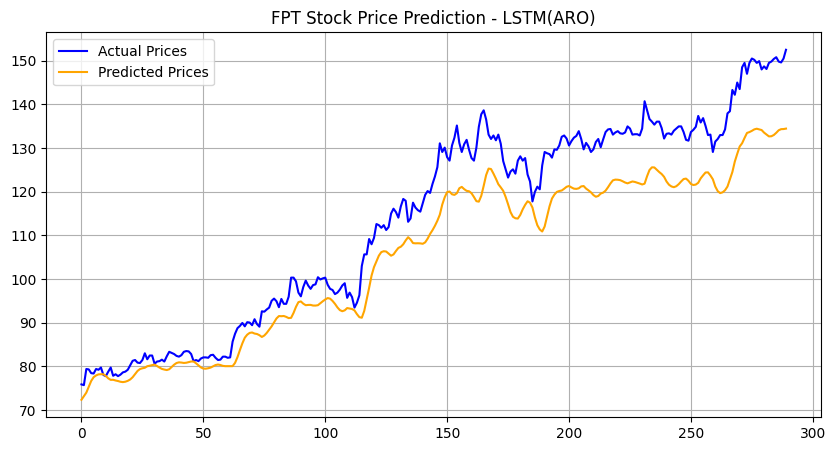

In [17]:
plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('FPT Stock Price Prediction - LSTM(ARO)')
plt.legend()
plt.grid(True)
plt.show()

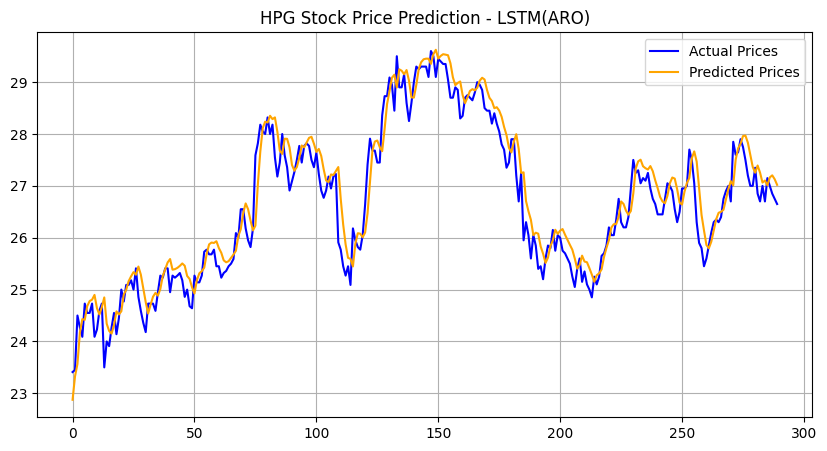

In [11]:
plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('HPG Stock Price Prediction - LSTM(ARO)')
plt.legend()
plt.grid(True)
plt.show()

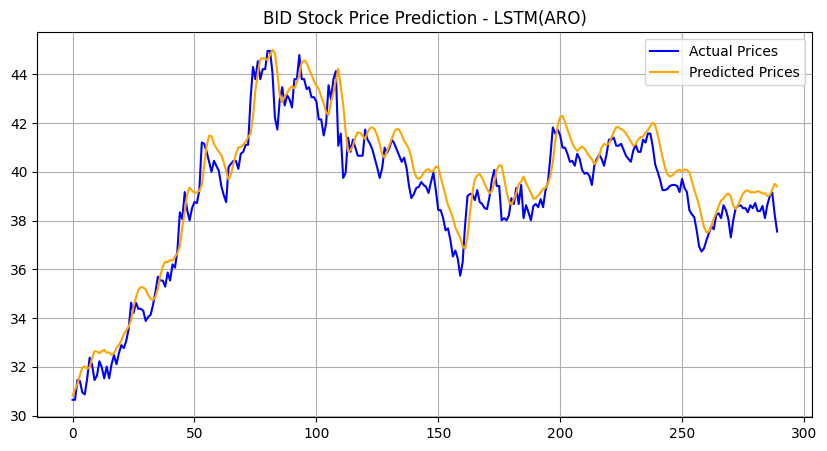

In [12]:
plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('BID Stock Price Prediction - LSTM(ARO)')
plt.legend()
plt.grid(True)
plt.show()

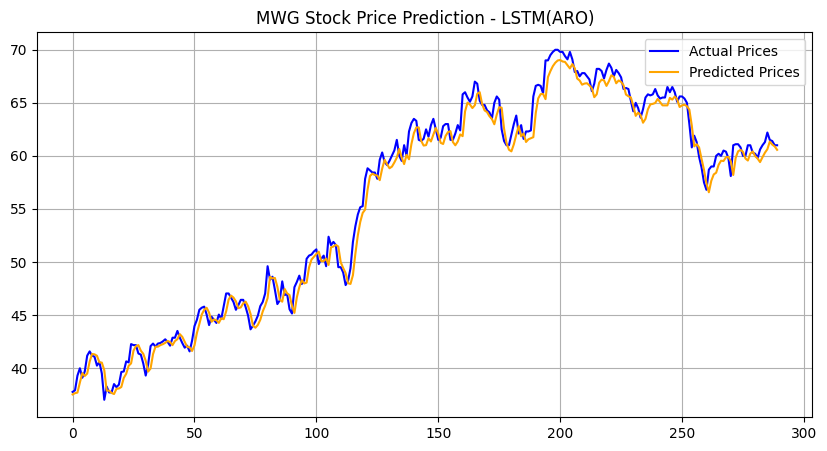

In [22]:
plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('MWG Stock Price Prediction - LSTM(ARO)')
plt.legend()
plt.grid(True)
plt.show()

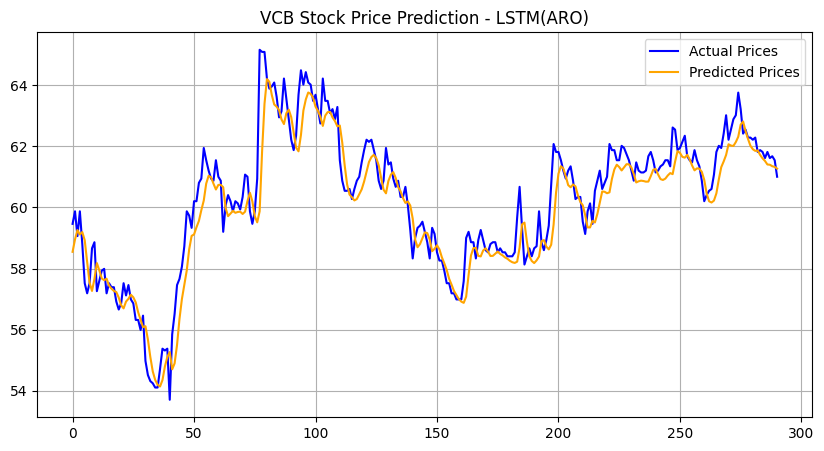

In [27]:
plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('VCB Stock Price Prediction - LSTM(ARO)')
plt.legend()
plt.grid(True)
plt.show()

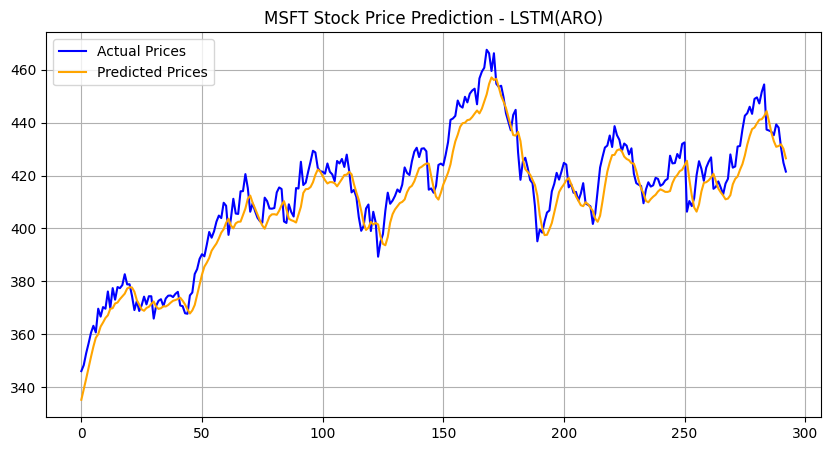

In [7]:
plt.figure(figsize=(10,5))
plt.plot(actual_test_price,label='Actual Prices', color='blue')
plt.plot(prediction_test_price,label='Predicted Prices', color='orange')
plt.title('MSFT Stock Price Prediction - LSTM(ARO)')
plt.legend()
plt.grid(True)
plt.show()